In [1]:
# jupyter nbconvert HW4.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove-cell"}' --to pdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
%matplotlib inline
%config InlineBackend.figure_format = 'png'

from pylab import rcParams
rcParams.update({"axes.grid" : True})
rcParams['figure.figsize'] = (6,4)
rcParams['lines.linewidth'] = 1
rcParams['image.cmap'] = 'Greys'
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.weight'] = 400
rcParams['font.size'] = 9
rcParams['xtick.color'] = '#111111'
rcParams['ytick.color'] = '#111111'
rcParams['grid.color'] = '#dddddd'
rcParams['grid.linestyle'] = '-'
rcParams['grid.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.titleweight'] = 500
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 400
rcParams['axes.linewidth'] = 0.5
rcParams['axes.edgecolor'] = [.25,.25,.25]

# Question 1 [35 Points] Regression and Optimization with Huber Loss

When fitting linear regressions, outliers could significantly affect the fitting results. However, manually checking and removing outliers can be tricky and time consuming. Some regression methods address this problem by using a more robust loss function. For example, one such regression is to minimize the objective function 

$$
\frac{1}{n} \sum_{i=1}^n \ell_\delta(y_i - x_i^\text{T} \boldsymbol \beta),
$$

where the loss function $\ell_{\delta}$ is the __Huber Loss__, defined as
$$
\ell_\delta( a ) =   \begin{cases}
    \frac{1}{2} a^2       & \quad \text{if } |a| \leq \delta \\
    \delta(|a| - \frac{1}{2} \delta)  & \quad \text{o.w.}
  \end{cases}
$$

Here is a visualization that compares Huber loss with the $\ell_2$ loss. We can see that the Huber loss assigns much less value when $y_i - x_i^\text{T} \boldsymbol \beta$ is more extreme (outliers). 

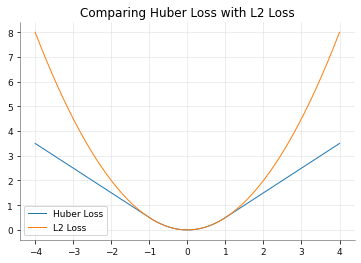

In [2]:
def Huber(a, delta = 1):
    to_return = np.where(np.abs(a)<=delta, 0.5*np.power(a,2), delta*(np.abs(a)-0.5*delta))
    return to_return
    
# def Huber(a, delta = 1):
#     return delta*delta*(np.power(1+np.power((a/delta),2),0.5)-1)

x = np.linspace(-4,4,1000)
huber_y = Huber(x)
l2_y = 0.5 * np.power(x,2)
plt.plot(x,huber_y, label='Huber Loss')
plt.plot(x,l2_y, label='L2 Loss')
plt.legend()
plt.title("Comparing Huber Loss with L2 Loss")
plt.show()

Use the following code to generate the data (python equivalent to R code provided):

In [3]:
np.random.seed(542)
n = 150
x = np.random.uniform(size=(n,))
ones = np.ones(n)
X = np.column_stack((ones,x))
beta = np.array([0.5,1])
y = X@beta + np.random.normal(size=(n,))
y[X[:,1].argmin()] = -30

a) [5 pts] Fit an OLS model with the regular $\ell_2$ loss. Report your coefficients (do not report other information). Although this is only one set of samples, but do you expect this estimator to be biased based on how we set up the observed data? Do you expect the parameter $\beta_1$ to bias upwards or downwards? Explain your reason. Hint: is the outlier pulling the regression line slope up or down?

In [4]:
OLS_model = sm.OLS(y,X).fit()
print(f'Beta 0: {OLS_model.params[0]}\nBeta 1: {OLS_model.params[1]}')

Beta 0: -0.32252335404905697
Beta 1: 2.1994524885770206


It is expected that this estimator is biased because the algorithm is sensitive to outliers. This leads to a model that will not fit well to the majority of the data. Since the outlier is pulling the data down, we expect the slope of the line of best to pull the slope up, leading to upwards bias. 

b) [10 pts] Define your own Huber loss function `huberLoss(b, trainX, trainY)` given a set of observed data with tuning parameter $\delta = 1$. Here, `b` is a $p$-dim parameter vector, `trainX` is a $n \times p$ design matrix and $trainY$ is the outcome. This function should return a scalar as the empirical loss. You can use our `Huber` function in your own code. After defining this loss function, use the `optim()` function to solve the parameter estimates. Finally, report your coefficients.  
    - Use `b = (0, 0)` as the initial value.
    - Use `BFGS` as the optimization method.

In [5]:
def huberLoss(b, trainX, trainY):
    huber = Huber(trainY-trainX@b)
    return (np.sum(huber))/len(trainY)

res = minimize(huberLoss,np.array([0.0,0.0]), args=(X, y), method='BFGS')
print(f'Beta 0: {res.x[0]}\nBeta 1: {res.x[1]}')

Beta 0: 0.42098531186094384
Beta 1: 1.0660410224987118


c) [20 pts] We still do not know which method performs better in this case. Let's use a simulation study to compare the two methods. Complete the following

- Set up a simulation for 1000 times. At each time, randomly generate a set of observed data, but also force the outlier with our code `y[which.min(X[, 2])] = -30`.
- Fit the regression model with $\ell_2$ loss and Huber loss, and record the slope variable estimates.
- Make a side-by-side boxplot to show how these two methods differ in terms of the estimations. Which method seem to have more bias? and report the amount of bias based on your simulation. What can you conclude from the results? Does this match your expectation in part a)? Can you explain this (both OLS and Huber) with the form of loss function, in terms of what their effects are?

OLS Bias: 1.2231792635017817
Huber Bias: 0.0685168644248868


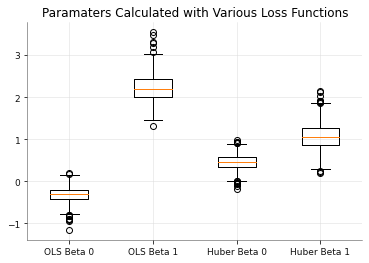

In [6]:
np.random.seed(542)
OLS_beta0s = []
OLS_beta1s = []

Huber_beta0s = []
Huber_beta1s = []

for i in range(1000):
    # Generate Data:
    n = 150
    x = np.random.uniform(size=(n,))
    ones = np.ones(n)
    X = np.column_stack((ones,x))
    beta = np.array([0.5,1])
    y = X@beta + np.random.normal(size=(n,))
    y[X[:,1].argmin()] = -30
    
    # OLS loss:
    OLS_model = sm.OLS(y,X).fit()
    OLS_beta0s.append(OLS_model.params[0])
    OLS_beta1s.append(OLS_model.params[1])
    
    # Huber loss:
    res = minimize(huberLoss,np.array([0.0,0.0]), args=(X, y), method='BFGS')
    Huber_beta0s.append(res.x[0])
    Huber_beta1s.append(res.x[1])

OLS_beta1 = np.array(OLS_beta1s).mean()
OLS_bias = OLS_beta1 - beta[1]

Huber_beta1 = np.array(Huber_beta1s).mean()
Huber_bias = Huber_beta1 - beta[1]

print(f'OLS Bias: {OLS_bias}\nHuber Bias: {Huber_bias}')

plt.boxplot([OLS_beta0s, OLS_beta1s, Huber_beta0s, Huber_beta1s])
plt.xticks([1,2,3,4],['OLS Beta 0','OLS Beta 1','Huber Beta 0','Huber Beta 1'])
plt.title('Paramaters Calculated with Various Loss Functions')
plt.show()

It appears that OLS has a higher bias (as we expected). Huber loss does not peanilize as much when the difference between the truth and prediction is very high, as indicated by the wider nature of the loss function. OLS peanilizes much more than Huber loss if the truth and prediction are different, as indicated by the narrow nature of the loss function. Adding an outlier will add a point that is very different leading to harsher penality with OLS. 

# Question 2 [65 Points] Scaling and Coordinate Descent for Linear Regression

**Scaling issue** In the practice, we usually standardize each covariate/feature to mean 0 and standard deviation 1. Standardization is essential when we apply $\ell_2$ and $\ell_1$ penalty on the loss function, because if the covariates are with different scales, then they are penalized differently. Without prior information, we should prevent that from happening. Besides, scaling the data also help to make the optimization more stable, since the step size in many descent algorithms could be affected by the scale.

In practice, after obtaining the coefficients fitted with scaled data, we want to recover the original coefficients of the unscaled data. For this question, we use the following intuition:

\begin{align}
\frac{Y - \bar{Y}}{\text{sd}_y} =&~ \sum_{j=1}^p \frac{X_j - \bar{X}_j}{\text{sd}_j} \gamma_j \\
Y =&~ \underbrace{\bar{Y} - \sum_{j=1}^p \bar{X}_j \frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_0} + \sum_{j=1}^p X_j \underbrace{\frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_j},
\end{align}

  * In this equation, the first line is the model fitted with scaled and centered data. And we obtain the fitted parameters as $\gamma_j$'s
  * In the second line, the coefficients $\beta_j$'s for the original data is recovered.
  * When fitting the scaled and centered data, no intercept term is needed. 

Based on this relationship, we perform the following when fitting a linear regression:

  * Center and scale both $\mathbf{X}$ (column-wise) and $\mathbf{y}$ and denote the processed data as $\frac{Y - \bar{Y}}{\text{sd}_y}$ and $\frac{X_j - \bar{X}_j}{\text{sd}_j}$ in the above formula. Make sure that the standard error of each variable is 1 after scaling. This means that you should use $N$, not $N-1$ when calculating the estimation of variance. 
  * Fit a linear regression using the processed data based on the no-intercept model, and obtain the parameter estimates $\gamma_j$'s.
  * Recover the original parameters $\beta_0$ and $\beta_j$'s.

Use the following code to generate your data (python code equivalent to R code provided):

In [7]:
np.random.seed(10)
n = 20
p = 3

# Covariance Matrix and Mean:
V = np.full((3, 3), 0.3)
np.fill_diagonal(V, 1.0)
mean = np.array([0.0,0.0,0.0])

# Generate Data:
X_org = np.random.multivariate_normal(mean, V, size=20)
true_b = np.array([1.0,2.0,0.0])
y_org = X_org @ true_b + np.random.normal(size=(n,))

a) [10 pts] Fit an OLS estimator with the original data `Y_org` and `X_org` by `lm()`. Also, fit another OLS with scaled data by `lm()`. Report the coefficients/parameters. Then, transform coefficients from the second approach back to its original scale, and match with the first approach. Summarize your results in a single table: The rows should contain three methods: OLS, OLS Scaled, and OLS Recorded, and there should be four columns that represents the coefficients for each method. You can consider using the `kable` function, but it is not required. 

In [8]:
mean_X = X_org.mean(axis=0)
sd_X = X_org.std(axis=0)

mean_y = y_org.mean()
sd_y = y_org.std()

X_processed = (X_org - mean_X)/sd_X
y_processed = (y_org - mean_y)/sd_y

X_org = sm.add_constant(X_org)
model_org = sm.OLS(y_org,X_org)
results_org = model_org.fit()

beta0 = results_org.params[0]
beta1 = results_org.params[1]
beta2 = results_org.params[2]
beta3 = results_org.params[3]
betas = np.array([beta0, beta1, beta2, beta3])

model_standardized = sm.OLS(y_processed,X_processed)
results_standardized = model_standardized.fit()

gama0 = 0.0
gama1 = results_standardized.params[0]
gama2 = results_standardized.params[1]
gama3 = results_standardized.params[2]
gamas = np.array([gama0, gama1, gama2, gama3])

beta0_recovered = mean_y - np.sum(mean_X*((sd_y*gamas[1:])/sd_X))
beta1_recovered = (sd_y*gamas[1])/sd_X[0]
beta2_recovered = (sd_y*gamas[2])/sd_X[1]
beta3_recovered = (sd_y*gamas[3])/sd_X[2]

dict = {'OLS' : betas,
        'OLS Scaled' : gamas,
        'OLS Recovered' : [beta0_recovered, beta1_recovered, beta2_recovered, beta3_recovered]}
df = pd.DataFrame(dict)
# displaying the DataFrame
display(df.T)

,0,1,2,3
OLS,0.130692,0.738092,2.479597,0.115294
OLS Scaled,0.000000,0.364177,0.775572,0.040844
OLS Recovered,0.130692,0.738092,2.479597,0.115294


b) Instead of using the `lm()` function, write your own coordinate descent code to solve the scaled problem. This function will be modified and used next week when we code the Lasso method. Complete the following steps:

- [10 pts] i) Given the loss function $L(\beta) =  \| y - X\beta\|^2$ or  $\sum_{i=1}^n (y_i - \sum_{j=0}^p x_{ij} \beta_j)^2$, derive the updating/calculation formula of coefficient $\beta_j$, when holding all other covariates fixed. You must use LaTex to typeset your derivation with proper explaination of notations. Write down the formula (in terms of $y$, $x$ and $\beta$'s) of residual $r$ before and after this update. Based on our lecture, how to make the update of $r$ computationally efficient? 
$$
L(\beta) = \frac{1}{2}\| y - X\beta\|^2
$$
Say $X_{(-j)}$ is our design matrix with the $j^{th}$ column removed, meaning $X_{(-j)} \in R^{n \times (p-1)}$. Say $X_{(j)}$ is the $j^{th}$ column of our design matrix, meaning $X_{(j)} \in R^{n}$. Say $\beta_{(-j)}$ parameter vector without the $j^{th}$ element, meaning $\beta_{(-j)} \in R^{p-1}$. Say $\beta_{(j)}$ is our $j^{th}$ paramter, meaning $\beta_{(j)} \in R$. We can rewrite the loss function as:

$$
L(\beta) = \frac{1}{2}\| y - (X_{(-j)}\beta_{(-j)}+X_{(j)}\beta_{(j)})\|^2
$$

$$
L(\beta) = \frac{1}{2}\| y - X_{(-j)}\beta_{(-j)}-X_{(j)}\beta_{(j)}\|^2
$$

$$
\nabla L(\beta) = X_{(j)}^{T}(y - X_{(-j)}\beta_{(-j)} - X_{(j)}\beta_{(j)})
$$

$$
\nabla L(\beta) = X_{(j)}^{T}(y - X_{(-j)}\beta_{(-j)}) - X_{(j)}^{T}X_{(j)}\beta_{(j)} = 0
$$

$$
\beta_{(j)} = \frac{X_{(j)}^{T}(y - X_{(-j)}\beta_{(-j)})}{X_{(j)}^{T}X_{(j)}}
$$
Now let $r = y - X_{(-j)}\beta_{(-j)}$:
$$
\beta_{(j)} = \frac{r^{T}X_{(j)}}{X_{(j)}^{T}X_{(j)}}
$$
In order to make our computation of r efficient, we realize that if we remember the old value of r, we can use it to update using this rule:

$$
r^{new} = r - X_{(j)}\beta_{(j)}^{(k+1)} + X_{(j+1)}\beta_{(j+1)}^{(k)}
$$

- [30 pts] ii) Implement this coordinate descent method with your own code to solve OLS with the scaled data. Print and report your **scaled coefficients** (no need to recover the original version) and compare with the result from the previous question.
    - Do not use functions from any additional library.
    - Start with a vector $\boldsymbol \beta = 0$.
    - Run your coordinate descent algorithm for a maximum of maxitr = 100 iterations (while each iteration will loop through all variables). However, stop your algorithm if the $\beta$ value of the current iteration is sufficiently similar to the previous one, i.e., $\|\beta^{(k)}− \beta ^{(k−1)}\|_1 \leq$ tol. Set `tol = 1e-7` where $\| \cdot \|_1$ is the L1 distance.

In [9]:
n = X_processed.shape[0]
p = X_processed.shape[1]
tol = 1e-7

betas_cd = np.zeros(p)
betas_cd_old = np.ones(p)

lossks = []
true_losses = []

# Loop over iterations
for iteration in range(100):
    betas_to_set = np.zeros(p)
    lossk = (y_processed - X_processed @ betas_cd).T @ (y_processed - X_processed @ betas_cd)
    true_loss = (y_processed - X_processed @ gamas[1:]).T @ (y_processed - X_processed @ gamas[1:])
    lossks.append(lossk)
    true_losses.append(true_loss)
    
    # initialize r
    r = y_processed - X_processed.dot(betas_cd)
    for j in range(p):
        # update r and betas
        r = r + X_processed[:, j] * betas_cd[j]
        betas_to_set[j] = (r.T @ X_processed[:, j])/n
        r = r - X_processed[:, j] * betas_cd[j]
    
    # tolerance check
    if(np.linalg.norm((betas_cd - betas_to_set), ord=1) <= tol):
        print(f'Converged at {iteration}')
        break
        
    betas_cd = betas_to_set

dict = {
        'OLS' : betas,
        'OLS Scaled' : gamas,
        'OLS Recovered' : [beta0_recovered, beta1_recovered, beta2_recovered, beta3_recovered],
        'Coordinate Descent': [0, betas_cd[0], betas_cd[1], betas_cd[2]]
       }

df = pd.DataFrame(dict)
display(df.T)

Converged at 29


,0,1,2,3
OLS,0.130692,0.738092,2.479597,0.115294
OLS Scaled,0.000000,0.364177,0.775572,0.040844
OLS Recovered,0.130692,0.738092,2.479597,0.115294
Coordinate Descent,0.000000,0.364177,0.775572,0.040844


- [5 pts] Make a plot to analyze the convergence of the coordinate descent. On the x-axis, we use the number of iteration. On the y-axis, use $\log(\text{Loss}_k - \text{trueLoss})$. Here, $\text{trueLoss}$ is the emperical loss based on the true optimizor, which we can simply use the solution from the `lm()` function (the scaled version). The $\text{loss}_k$ is the loss function at the begining of the $k$-th iteration (Keep in mind that within each iteration, we will loop over all $\beta_j$). If this plot displays a stragiht line, then we say that this algorithm has a linear convergence rate. Of course, this is at the log scale. 

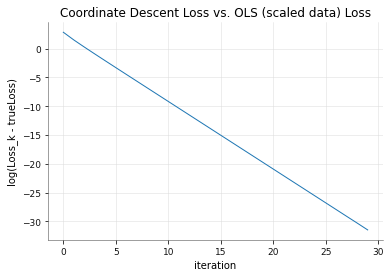

In [10]:
to_plot = np.log(np.array(lossks) - np.array(true_losses))
plt.plot(to_plot)
plt.title("Coordinate Descent Loss vs. OLS (scaled data) Loss")
plt.xlabel("iteration")
plt.ylabel("log(Loss_k - trueLoss)")
plt.show()